In [1]:
import VoltageGeneration

In [2]:
import os
import os.path
import time

In [3]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as sciopt

colors = ["#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", \
          "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", \
          "#8FB0FF", "#997D87", "#5A0007", "#809693", "#FFAA92", "#1B4400", \
          "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80", "#61615A", "#BA0900", \
          "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100", \
          "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", \
          "#013349", "#00846F", "#372101", "#FFB500", "#C2FFED", "#A079BF", \
          "#CC0744", "#C0B9B2", "#C2FF99", "#001E09", "#00489C", "#6F0062"]

%load_ext autoreload
%autoreload 2

In [4]:
amu = 1.66e-27
elem_charge = 1.602e-19
m = 88 * amu

kHz = 1e3
MHz = 1e6

In [5]:
# New style, on wax

# Ordering for the standard trap configuration
electrode_ordering = [
        "S6", "S7", "S8", "S9", "S10", "S11", "S12", "S13", "S14",
        "S24", "S25",
        "N6", "N7", "N8", "N9", "N10", "N11", "N12", "N13", "N14",
]

In [6]:
##Need to convert to the new style!

# Ordering for the maxbeta configuration
electrode_ordering = [
    "S1", "S2", "S3", "S4", "S8", "S9", "S10", "S11", "S12",
    "S13", "S14", "S19", "S20", "S21",
    "S22", "S23", "S24", "S25",
    "N1", "N2", "N3", "N4", "N8", "N9", "N10", "N11", "N12",
    "N13", "N14", "N19", "N20", "N21",
]
artiq_electrode_ordering = [
    27, 25, 23, 21, 19, 17, 15, 13, 11,
    9, 7, 5, 3, 1,
    32, 31, 30, 29,
    2, 4, 6, 8, 10, 12, 14, 16, 18,
    20, 22, 24, 26, 28
]

# converts grid file number to electrode
def num_to_electrode_name(num):
    grid_num = artiq_electrode_ordering.index(num)
    return electrode_ordering[grid_num]

In [7]:
def rotate_coeffs(theta, xx, xz, zz):
    """
    Find the coefficients $C'_{xx}, C'_{xz}, C'_{zz}$ of the potential
    after a rotation in the zx-plane by `theta` given the unprimed values,
    as described above.
    
    `theta` specified in radians.
    """
    sin = np.sin
    cos = np.cos
    
    xxnew = xx*cos(theta)**2 + zz*sin(theta)**2 + 0.5*xz*sin(2*theta)
    xznew = xz*cos(2*theta)  + (zz-xx)*sin(2*theta)
    zznew = zz*cos(theta)**2 + xx*sin(theta)**2 - 0.5*xz*sin(2*theta)
    
    return [xxnew, xznew, zznew]

In [8]:
def dcTiltAngle(vg, R, theta_targ, yy, rfEls, delta=3, debug=False):
    # expansion coefficients of the pseudopotential near the trapping point `R`
    # THIS FUNCTION ASSUMES ONE RF ELECTRODE!
    rf_coeffs = vg.printCoefficients(R, rfEls, ('zz', 'xx', 'xz', 'yy', 'xy', 'yz'), printing=False)[0]
    [rfzz, rfxx, rfxz, rfyy, rfxy, rfyz] = rf_coeffs[:,0]
    
    def tiltError(theta_tilt, debug=False):
        """
        Error in the tilt angle of the full potential, as a function of the dc tilt.
        """
        
        zz = delta*yy
        xx = -(1+delta)*yy # delta ensures Laplace (div phi = 0) is satisfied, but adjusts the principal axes of the xz ellipse
        xz = 0
        
        # rotate!
        [xxnew, xznew, zznew] = rotate_coeffs(theta_tilt, xx, xz, zz)

        if debug:
            print (np.degrees(theta_tilt))
            print (np.degrees(np.arctan((xznew+rfxz)/((rfzz+zznew) - (rfxx+xxnew))))/2)
        
        return (
            np.tan(2*theta_targ) - (xznew+rfxz)/((rfzz+zznew) - (rfxx+xxnew))
        )**2
    
    if debug:
        print (np.degrees(theta_targ))

        fig, ax = plt.subplots()
        angle_space = np.linspace(0, np.pi/2, 91)
        errors = [tiltError(theta) for theta in angle_space]
        ax.plot(np.degrees(angle_space), errors)
        ax.set_ylim(0,1)
    
    return sciopt.minimize_scalar(tiltError).x

def tiltWithPseudo(vg, R, theta_targ, yy, rfEls, delta=3, debug=False):
    th = dcTiltAngle(vg, R, theta_targ, yy, rfEls, delta=delta, debug=debug)
    
    if debug:
        print ("Tilting dc to {:.2f} deg".format(np.degrees(th)))
    
    zz = delta*yy
    xx = -(1+delta)*yy
    xz = 0
    return rotate_coeffs(th, xx, xz, zz)

In [9]:
#COMSOL grid files
# path = r'C:\Users\Ions\Documents\COMSOL\CenterSegmentation\ParsedGridFiles'
# name = "MaxBeta_Production_Potential"
# path = "N:\\Programs\\Ions Share\\TrapFiles\\LL Standard Traps\\GridFiles\\"
# name = "AngleTrap_Skinny_Subsample_Full_Potential"
# path = "N:\\Programs\\Ions Share\\TrapFiles\\MZTWINWAC\\GridFiles\\"
# name = "MZTWINWAC_Potential"
path = '/Users/lukeqi/Desktop/School/MIT/UROP/SuperUROP/GridFiles'
name = 'MaxBeta_Production_Potential'


# electrode_grouping = [[x] for x in artiq_electrode_ordering]
electrode_grouping = [[i+1] for i in range(len(electrode_ordering))]
d_cons = [('x',0), ('y',0), ('z',0)]

start_time = time.time()

vg_comsol = VoltageGeneration.VoltageGeneration(
    path,
    name,
    electrode_grouping,
    rf_electrodes=[23],
    m=m,
    rf_omega=2.*np.pi*45.247E6,
    order=2,
    f_cons=d_cons,
    v_rf=[67.2]
    #v_rf=[50.0]
)

print("Imported grid files in {}".format(time.time() - start_time))

Importing electrode 9
Importing electrode 8
Importing electrode 23
Importing electrode 22
Importing electrode 20
Importing electrode 21
Importing electrode 19
Importing electrode 31
Importing electrode 25
Importing electrode 24
Importing electrode 30
Importing electrode 18
Importing electrode 26
Importing electrode 32
Importing electrode 33


KeyboardInterrupt: 

In [64]:
voltage_gen = vg_comsol

sec_freq = 1200*kHz
omega = 2 * np.pi * sec_freq

# trap_center = [0.0, -120.0, 50.0]
trap_center = [0.0, -120.0, 51.7]
R = [trap_center]

tilt_angle_deg = 15 #in degrees
tilt_angle = np.radians(tilt_angle_deg)

yycons = 0.5 * m * omega**2 * (1e-6)**2 / elem_charge
[xxt, xzt, zzt] =  tiltWithPseudo(voltage_gen, R, tilt_angle, yycons, voltage_gen.rf_electrodes, debug=False)
cons = [('xx', xxt), ('yy', yycons), ('zz', zzt), ('xz', xzt), ('yz', 0), ('xy', 0)]

# cons += [('x', 0.0), ('y', 0.0), ('z', -96.0 * -1e-4)]
[('x', 0.0), ('y', 0.0), ('z', 0.0 * -1e-4)]

print("target alpha = %.2E"%(yycons/(1e-6)**2))

# constrained_voltages = [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0),
#                         (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0),
#                         (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0),
#                         (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0),
#                         (30, 0.0), (31, 0.0),
#                        ]
constrained_voltages = []

nom_voltages = voltage_gen.findControlVoltages(
    R,
    cons=[cons],
    tol=1e-13,
    fixed_voltages=constrained_voltages,
    bnds =(-39.9, 39.9),
    epss=1e-6,
)

el_config = []
for [num, voltage] in voltage_gen.ungroup_configuration(nom_voltages):
    el_config.append([[num], voltage])

print(el_config)

_ = voltage_gen.compute_total_potential_axes(R, el_config, printing=True)

target alpha = 2.59E+07
Optimization failed after 10001 iterations.
Target, Realized Coeffs:
 [[ 0.00000000e+00 -2.81819872e-09]
 [ 0.00000000e+00 -1.73471215e-09]
 [ 0.00000000e+00 -7.02365633e-09]
 [-8.39918373e-05 -8.39750600e-05]
 [ 0.00000000e+00  9.26548071e-09]
 [ 1.12853619e-04  1.12850480e-04]
 [ 2.59191337e-05  2.59656090e-05]
 [ 0.00000000e+00  8.30441588e-09]
 [ 5.80727036e-05  5.80753553e-05]]
Final cost value:  1.278557586332738e-06 

[[[1], 6.101857280225361], [[2], 5.409755646489312], [[3], 3.3352612073577905], [[4], -17.232885746056308], [[5], 4.161208621508281], [[6], 7.560055365341227], [[7], 4.287166837753997], [[8], 2.462594588950339], [[9], 5.4077897648453215], [[10], -1.00567705949358], [[11], 1.3733284060444544], [[12], 5.1909736112422555], [[13], 2.340267836955552], [[14], 4.005047883046038], [[15], 6.861644303542932], [[16], 2.115468548613537], [[17], -20.917423786114945], [[18], 1.2520817820367998], [[19], 4.708456089364284], [[20], 5.456013138712128]]
coeffs

Export voltage set to a simple npy file

In [65]:
voltage_set_to_export = nom_voltages
file_path = r'N:\Individual Folders\Stuart\xfer'
file_name = os.path.join(file_path, "NominalVolts_20200527_NOHOLENITO_1p60_0um.npy")

# print(file_name)

el_config = []
for [num, voltage] in voltage_gen.ungroup_configuration(nom_voltages):
    el_config.append([[num], voltage])
    
# print(el_config)

voltages_dict = {electrode_ordering[num-1]: v/4.0 for [[num], v] in el_config}

# print(voltages_dict)

for electrode in electrode_ordering:
    print(electrode, voltages_dict[electrode])

# np.save(file_name, voltages_dict)

S6 1.5254643200563403
S7 1.352438911622328
S8 0.8338153018394476
S9 -4.308221436514077
S10 1.0403021553770702
S11 1.8900138413353067
S12 1.0717917094384992
S13 0.6156486472375847
S14 1.3519474412113304
S24 -0.251419264873395
S25 0.3433321015111136
N6 1.2977434028105639
N7 0.585066959238888
N8 1.0012619707615096
N9 1.715411075885733
N10 0.5288671371533843
N11 -5.229355946528736
N12 0.31302044550919994
N13 1.177114022341071
N14 1.364003284678032


Load simple npy file and print fit results

In [111]:
#myvolts = np.load('N:\\Individual Folders\\Stuart\\xfer\\NominalVolts_20200310_MZTWINWAC_1p20_0um.npy').item()
myvolts = np.load('N:\\Individual Folders\\Stuart\\xfer\\NominalVolts_20200527_NOHOLENITO_0p60_0um.npy').item()

voltages = []
for electrode_name in _electrode_ordering:
    voltages.append(myvolts[electrode_name])

print(voltages)
    
el_config = []
for index, voltage in enumerate(voltages):
    el_config.append([[index+1], voltage])

print(el_config)
    
expansion_point = [[0., 0.0, 50.]]

#vg.compute_total_potential_axes(expansion_point, el_config, printing=True)
voltage_gen.compute_total_potential_axes(expansion_point, el_config, printing=True)

[1.2766968394577807, 0.7850216607830579, 1.6249859372732356, 1.102789878280131, -4.405680527119563, 1.1103292907863085, 1.6253085726907313, 0.7823467501589556, 1.178181754741407, -0.12790327350682212, 0.3148507655064507, 1.2245065272693634, 0.7335935526612137, 1.496330963524113, 0.7164594146895802, -5.088154471155908, 0.7264475487701444, 1.4977732613836587, 0.7329026355064064, 1.1224808079433342]
[[[1], 1.2766968394577807], [[2], 0.7850216607830579], [[3], 1.6249859372732356], [[4], 1.102789878280131], [[5], -4.405680527119563], [[6], 1.1103292907863085], [[7], 1.6253085726907313], [[8], 0.7823467501589556], [[9], 1.178181754741407], [[10], -0.12790327350682212], [[11], 0.3148507655064507], [[12], 1.2245065272693634], [[13], 0.7335935526612137], [[14], 1.496330963524113], [[15], 0.7164594146895802], [[16], -5.088154471155908], [[17], 0.7264475487701444], [[18], 1.4977732613836587], [[19], 0.7329026355064064], [[20], 1.1224808079433342]]
coeffs with the RF: [ 5.47053378e-08  2.04947854e

(array([[ 2.55387589e-04, -2.08029995e-10,  1.01742004e-05],
        [-2.08029995e-10,  6.46601068e-06,  2.28825554e-08],
        [ 1.01742004e-05,  2.28825554e-08,  2.90649066e-04]]),
 array([ 599361.92728667, 3746635.55974118, 4037215.097541  ]),
 array([[ 4.13289551e-06,  9.99999997e-01, -8.06684412e-05],
        [ 9.65952865e-01, -2.48625692e-05, -2.58718113e-01],
        [ 2.58718114e-01,  7.68526569e-05,  9.65952862e-01]]))

Simplified version of nominal and shim exports

In [76]:
output_path = 'C:\\Users\\Ions\\Documents\\ARTIQ\\Voltages\\'
filename_spec = '20201119_MAXBETA_1p80_540um'
axial_freq = 1800*kHz
tilt = 15
trap_pos = [0, 540.0, 50]
constrained_voltages = [(0, 0.0), (1, 0.0), (2, 0.0), (3, 0.0), (4, 0.0),
                        (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0),
                        (21, 0.0), (22, 0.0), (23, 0.0), (24, 0.0),
                        (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0),
                        (30, 0.0), (31, 0.0),
                       ]

electrode_ordering = [
    "S1", "S2", "S3", "S4", "S8", "S9", "S10", "S11", "S12",
    "S13", "S14", "S19", "S20", "S21",
    "S22", "S23", "S24", "S25",
    "N1", "N2", "N3", "N4", "N8", "N9", "N10", "N11", "N12",
    "N13", "N14", "N19", "N20", "N21",
]

###

omega = 2 * np.pi * axial_freq
convexity = 1 if axial_freq > 0 else -1  # allow anti-confining potentials
tilt_angle = np.radians(tilt)
R = [trap_pos]

yycons = 0.5 * m * convexity * omega**2 * (1e-6)**2 / elem_charge
[xxt, xzt, zzt] =  tiltWithPseudo(voltage_gen, R, tilt_angle, yycons, voltage_gen.rf_electrodes, debug=False)
cons = [('xx', xxt), ('yy', yycons), ('zz', zzt), ('xz', xzt), ('yz', 0), ('xy', 0)]

t = time.time()
nom_voltages = voltage_gen.findControlVoltages(
    R,
    cons=[cons],
    tol=1e-14,
    fixed_voltages=constrained_voltages,
    bnds=(-9.9, 9.9),
)

shift_voltages = []
for ind, direction in enumerate(['x', 'y', 'z']):
    # Add a small field in the particular direction by adding a linear constraint
    R = [trap_pos]
    if direction == 'y':
        newcons = cons + [(direction, -1e-4)] #Sign convention is done to be consistent with a positive displacement
    else: # Try fitting with a larger shift and dividing down
        newcons = cons + [(direction, -1e-3)] #Sign convention is done to be consistent with a positive displacement

    # get the voltages needed for a shift by subtracting the nominal voltages
    shift_voltage_set = voltage_gen.findControlVoltages(
        R,
        cons=[newcons],
        tol=1e-14,
        fixed_voltages=constrained_voltages,
        bnds=(-9.9, 9.9),
    )
    shift_voltage_set -= nom_voltages
    
    if not direction == 'y':
        shift_voltage_set /= 10.0
    shift_voltages.append(shift_voltage_set)

# Save to file

nom_voltages_file_path = os.path.join(output_path, "NominalVolts_{}.npy".format(filename_spec))
nom_voltages_dict = {electrode_ordering[num-1]: v for [num, v] in voltage_gen.ungroup_configuration(nom_voltages)}
np.save(nom_voltages_file_path, nom_voltages_dict)

for axis, shift_v in zip(['X', 'Y', 'Z'], shift_voltages):
    shift_voltages_file_path = os.path.join(output_path, "{}DeltaVolts_{}.npy".format(axis, filename_spec))
    shift_voltages_dict = {electrode_ordering[num-1]: v for [num, v] in voltage_gen.ungroup_configuration(shift_v)}
    np.save(shift_voltages_file_path, shift_voltages_dict)
    
np.save(os.path.join(output_path, "Shims_{}.npy".format(filename_spec)), np.array([0., 0., 0.]))

need to get rid of stuff below

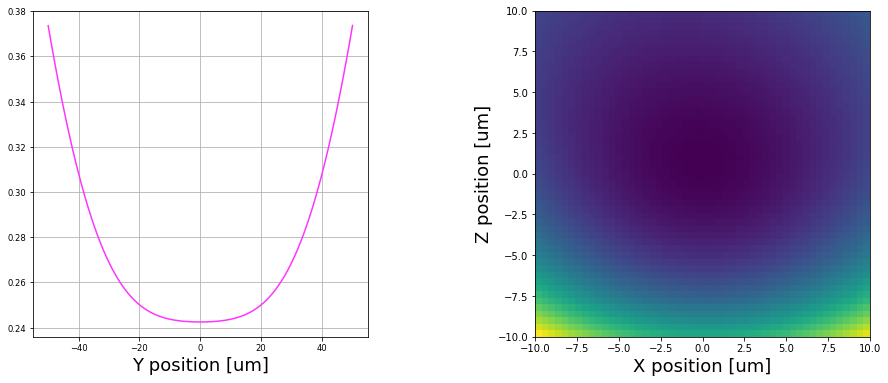

In [41]:
#Plot the three cross sections of the given potential

R = [[0.0, 559.5, 50.0]]
input_voltages = nom_voltages
voltage_gen = vg_comsol
#voltage_gen = vg_bempy
#voltage_gen = vg_biotsavart

el_config = voltage_gen.ungroup_configuration(input_voltages)
for el in voltage_gen.rf_electrodes:
    el_config.append([el, 1])

y_span_um = 50
n_y_points = 100
y_points = np.linspace(-y_span_um, y_span_um, n_y_points)
y_test_points = np.array([np.zeros(n_y_points), y_points, np.zeros(n_y_points)]).T + R
y_exact_potential = voltage_gen.compute_potential(y_test_points, el_config)

pseudo_cross_section = []

x_span_um = 10
n_x_points = 50
x_points = np.linspace(-x_span_um, x_span_um, n_x_points)

z_span_um = 10
n_z_points = 50
z_points = np.linspace(-z_span_um, z_span_um, n_z_points)

for z_point in z_points:
    test_points = np.array([x_points, np.zeros(n_x_points), np.full(n_x_points, z_point)]).T + R
    xz_exact_potential = voltage_gen.compute_potential(test_points, el_config)
    pseudo_cross_section.append(xz_exact_potential)

nice_fs = 12    #Nice font size
nice_lw = 4     #Nice linewidth

fig = plt.figure(figsize=(15,6))
plt.subplots_adjust(wspace=0.5)

ax_yslice = fig.add_subplot(1, 2, 1)
ax_yslice.set_xlabel('Y position [um]', size=nice_fs*1.5)
#ax_yslice.set_ylabel('Potenial [V]', size=nice_fs*1.5)
ax_yslice.tick_params(axis='both', which='major', labelsize=nice_fs*0.7)

ax_yslice.plot(y_points, y_exact_potential, '-', c=colors[1], label='DATA')
ax_yslice.grid(True, which="both")

ax_xzslice = fig.add_subplot(1, 2, 2)

ax_xzslice.set_xlabel('X position [um]', size=nice_fs*1.5)
ax_xzslice.set_ylabel('Z position [um]', size=nice_fs*1.5)

extent = [-x_span_um, x_span_um, -z_span_um, z_span_um]

# Plot heatmap
ax_xzslice.imshow(
    pseudo_cross_section,
    extent=extent,
    #vmin = 0.0,
    #vmax = 5.0,
    aspect = 'auto', # Prevent the image from getting stretched out
    interpolation = 'nearest', # ???
    origin = 'lower', # Important to do this so that the first row goes on the bottom
    cmap = 'viridis',
)

#plt.legend(prop={'size': 18})
plt.show()

In [78]:
output_path = 'C:\\Users\\Ions\\Documents\\ARTIQ\\Voltages\\'
filename_spec = 'maxbeta_zeros_0um'


###

nom_voltages = np.zeros(len(_electrode_ordering))

shift_voltages = []
for ind, direction in enumerate(['x', 'y', 'z']):
    shift_voltage_set = np.zeros(len(_electrode_ordering))
    shift_voltages.append(shift_voltage_set)

# Save to file

nom_voltages_file_path = os.path.join(output_path, "NominalVolts_{}.npy".format(filename_spec))
nom_voltages_dict = {electrode_ordering[num-1]: v for [num, v] in voltage_gen.ungroup_configuration(nom_voltages)}
np.save(nom_voltages_file_path, nom_voltages_dict)

for axis, shift_v in zip(['X', 'Y', 'Z'], shift_voltages):
    shift_voltages_file_path = os.path.join(output_path, "{}DeltaVolts_{}.npy".format(axis, filename_spec))
    shift_voltages_dict = {electrode_ordering[num-1]: v for [num, v] in voltage_gen.ungroup_configuration(shift_v)}
    np.save(shift_voltages_file_path, shift_voltages_dict)
    
np.save(os.path.join(output_path, "Shims_{}.npy".format(filename_spec)), np.array([0., 0., 0.]))

In [77]:
print(np.zeros(21))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
